In [1]:
import os

import numpy as np
import pandas as pd

import pint
import sympy

import sissotools
from sissotools import io
from sissotools import dimensional_analysis
from sissotools import regression
from sissotools import plotting

In [2]:
%matplotlib inline

# I/O Options

In [3]:
input_filename = "./data_AD.txt"
working_directory = "./demo"

In [4]:
if not os.path.isdir(working_directory):
    os.mkdir(working_directory)

# Read Data

In [5]:
# parse tab-separated-value file
df_ad = io.read_tsv(input_filename)

In [6]:
df_ad

,Tc,wlog,w1,w2,wph,eta,lambd,mus
material,,,,,,,,
Pb,7.20,56.0,60.0,65.0,110.0,2.4,1.550,0.105
In,3.40,68.0,79.0,89.0,179.0,1.3,0.805,0.097
Sn,3.75,99.0,110.0,121.0,209.0,2.2,0.720,0.092
Hg,4.19,29.0,38.0,49.0,162.0,1.4,1.600,0.098
Tl,2.36,52.0,58.0,64.0,127.0,1.2,0.795,0.111
Ta,4.48,132.0,140.0,148.0,228.0,4.9,0.690,0.093
alpha-Ga,8.56,55.0,77.0,101.0,291.0,2.1,1.620,0.095
beta-Ga,5.90,87.0,108.0,129.0,285.0,2.0,0.970,0.092
Tl0.9Bi0.1,2.30,48.0,55.0,62.0,120.0,1.1,0.780,0.099


# Data Inspection

In [7]:
# consider the target and a subset of features
column_names = ["Tc", "lambd", "wlog", "w2", "mus"]

In [8]:
# substitutions for visualization
latex_subs = {"mus": r"\mu^{\ast}",
              "wlog": r"\omega_{\mathrm{log}}",
              "w2": r"\omega_2",
              'lambd': r"\lambda",
              'Tc': r"T_c"}
label_substitutions = {k: r"${}$".format(v) for k, v in latex_subs.items()}

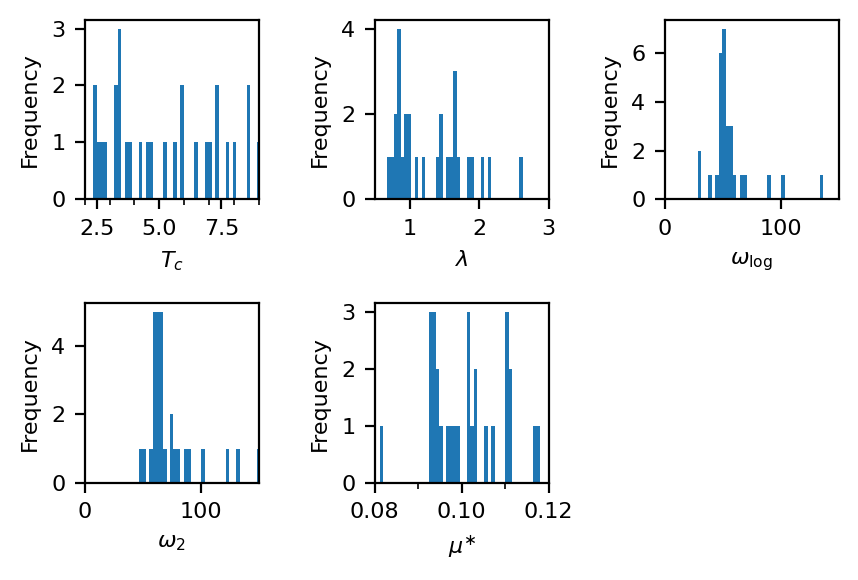

In [9]:
# visualize target and feature distributions
fig, ax = plotting.plot_distributions(df_ad, 
                                      column_names,
                                      label_substitutions=label_substitutions)
fig.tight_layout()

# Unit checking

In [10]:
# Consider known equations (McMillan 1968, Allen and Dynes 1975)
expr_mm = r'wlog / 1.2 * exp((-1.04 * (1 + lambd)) / (lambd - mus * (1 + 0.62 * lambd)))'

expr_f1 = r'((1 + ((lambd/(2.46*(1 + 3.8 * mus)))**1.5))**(1/3))'
expr_f2 = r'(1 + (((w2/wlog) - 1) * lambd**2)/(lambd**2 + (1.82*(1 + 6.3*mus)*(w2/wlog))**2))'
expr_ad = r'({}) * ({}) * ({})'.format(expr_mm, expr_f1, expr_f2)

In [11]:
# Dummy equation
expr_dummy = r"wlog * w2 * lambd * mus"

# Invalid equations
expr_dims = r"wlog - lambd"
expr_zero = r"w2 / (wlog - wlog)"

In [12]:
# Define units per feature
unit_ref = {'wlog': 'K',
            'w2': 'K',
            'lambd': 'dimensionless',
            'mus': 'dimensionless'}

In [13]:
# Check units
expr_list = [expr_mm, expr_f1, expr_f2, expr_ad, 
             expr_dummy, expr_dims, expr_zero]
name_list = ["McMillan Equation", 
             "Allen-Dynes f1",
             "Allen-Dynes f2",
             "Allen-Dynes Equation",
             "\nDummy equation",
             "Invalid equation",
             "Invalid equation"]

print("{0:<20} {1:>20} [{2}]".format("Name", "Units", "Degree"))
print("="*50)
for expr, name in zip(expr_list, name_list):
    dims, degree = dimensional_analysis.check_dimensionality(expr, 
                                                             unit_ref)
    dims = dims.replace('[', '').replace(']', '')
    print("{0:<20} {1:>20} [{2}]".format(name, dims, degree))

Name                                Units [Degree]
McMillan Equation             temperature [1]
Allen-Dynes f1              dimensionless [0]
Allen-Dynes f2              dimensionless [0]
Allen-Dynes Equation          temperature [1]

Dummy equation               temperature [2]
Invalid equation       Dimension Mismatch [0]
Invalid equation            Zero Division [0]


# Evaluating models

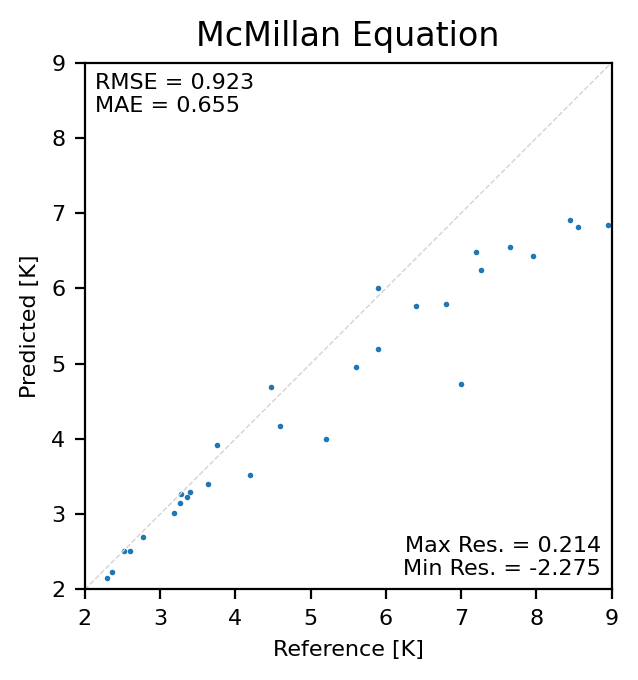

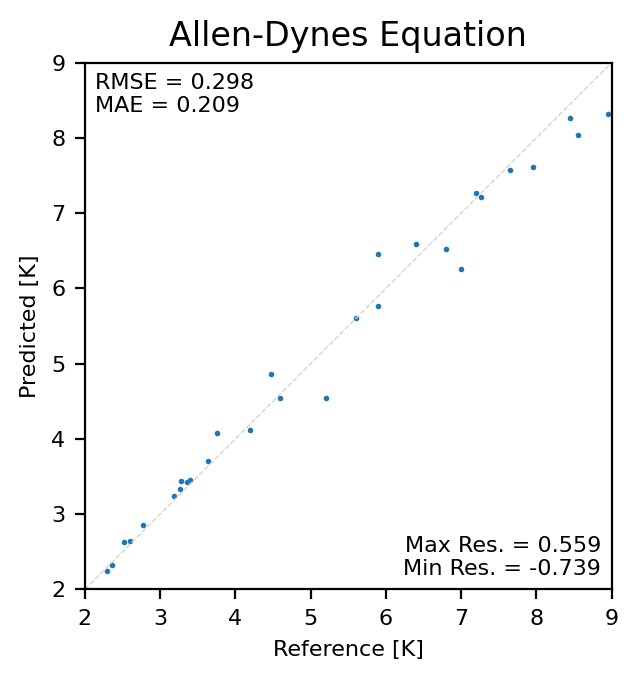

In [14]:
# Predict Tc using equations
slope = 1 # no slope
intercept = 0  # no intercept
coefficients = (slope, intercept)

features = column_names[1:]  # subset of features

values_mm, _ = regression.evaluate_model(expr_mm, 
                                         df_ad, 
                                         features,
                                         coefficients)
values_ad, _ = regression.evaluate_model(expr_ad, 
                                         df_ad, 
                                         features,
                                         coefficients)

# Validate against experimental reference measurements
fig, ax = plotting.pretty_scatter(df_ad['Tc'], values_mm, units="K")
ax.set_title("McMillan Equation")
fig.tight_layout()

fig, ax = plotting.pretty_scatter(df_ad['Tc'], values_ad, units="K")
ax.set_title("Allen-Dynes Equation")
fig.tight_layout()

# Writing SISSO inputs

In [15]:
# train.dat
column_names = ["Tc", "wlog", "lambd", "mus"]  # feature subset
df_train = df_ad[column_names]

filename = os.path.join(working_directory, "train.dat")
io.create_tsv(df_train, filename)

In [16]:
# the first dimension group includes the first feature
dimension_groups = "(1:1)"  
# ungrouped features (i.e. 2 and 3) are dimensionless

n_iterations = 3                     # number of subpsace expansion iterations (max 3)
n_train = len(df_train)              # number of training samples
n_features = len(column_names) - 1   # number of features
n_sis = 1000                         # SIS subspace size
n_models = 1000                      # number of models to save

problem_type = 1  # regression
operation_set = "'(+)(-)(*)(/)(exp)(exp-)(^-1)(^2)(^3)(sqrt)(log)'"
fit_intercept = False

parameters = dict(ptype=problem_type,
                  dimclass=dimension_groups,
                  rung=n_iterations,
                  opset=operation_set,
                  nsample=n_train,
                  nsf=n_features, 
                  subs_sis=n_sis, 
                  nm_output=n_models,
                  fit_intercept=fit_intercept)

filename = os.path.join(working_directory, "SISSO.in")
io.create_sisso_input(parameters, filename=filename)